# NAFLD detection using RNA-Seq data


__Content creators:__  Mahdi Anvari, Sadegh Rizi

**University of Tehran, Department of Biotechnology**

In this part, we need to split the classifiers from Part 1 into two connected machines and evaluate how the overall performance of the task changes.

# Q3 - Python section

For the first machine, we need to classify normal samples versus any type of fibrosis samples.

In [1]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# Load Data
normal_counts = pd.read_csv('Normal.counts.voom.csv')
meta_data = pd.read_csv('meta_data.csv')

In [3]:
def determine_class(row):
    if row['Simplified_class'] == 'Normal':
        return "Normal"
    else:
        return "Fibrosis"

In [4]:
meta_data['class'] = meta_data.apply(determine_class, axis=1)
meta_data = pd.DataFrame(meta_data)

In [5]:
meta_data

,Patient_ID,SEX,BMI_surg,Age,Run,Diabet,Simplified_class,class
0,DLDR_0001,Female,35.214555,55,SRR8378590,Non Diabetic,Normal,Normal
1,DLDR_0002,Female,39.421748,47,SRR8378589,Diabetic,Normal,Normal
2,DLDR_0003,Male,48.758108,46,SRR8378432,Non Diabetic,Normal,Normal
3,DLDR_0004,Female,41.822607,36,SRR8378431,Non Diabetic,Normal,Normal
4,DLDR_0005,Female,53.582192,54,SRR8378434,Non Diabetic,Normal,Normal
...,...,...,...,...,...,...,...,...
187,DLDR_0188,Male,40.216173,59,SRR8378532,Diabetic,Normal,Normal
188,DLDR_0189,Female,50.077601,52,SRR8378525,Non Diabetic,Normal,Normal
189,DLDR_0190,Male,104.921344,28,SRR8378526,Diabetic,Normal,Normal
190,DLDR_0191,Female,47.495069,36,SRR8378566,Non Diabetic,Normal,Normal


Let's split our data and labels to train and test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(normal_counts.iloc[0:,1:].T, meta_data[['Simplified_class', 'class']], test_size=0.3, random_state = 10101)

Now, let’s save the training set data to use in the R Jupyter Notebook for feature selection

In [7]:
X_train.T.to_csv('train_normal_counts.csv', index=False)
y_train.to_csv('train_meta_data.csv', index=False)

#### Run R Jupyter Notebook

Let's load the output of R to continue the task for the first machine classification

## First Machine

In [9]:
subset_data1 = pd.read_csv('subset_data1.csv')

In [10]:
subset_data1.head()

,Unnamed: 0,DLDR_0036,DLDR_0081,DLDR_0191,DLDR_0188,DLDR_0130,DLDR_0013,DLDR_0079,DLDR_0131,DLDR_0135,...,DLDR_0175,DLDR_0052,DLDR_0087,DLDR_0155,DLDR_0092,DLDR_0187,DLDR_0186,DLDR_0179,DLDR_0182,DLDR_0001
0,10,4.589555,5.482169,5.013154,5.066071,4.655817,4.299078,4.752957,5.409514,4.993777,...,4.853565,4.567173,4.985158,5.234776,4.900754,4.923087,5.004500,5.058062,5.002454,4.221450
1,17,5.449846,5.626559,5.668470,5.824931,5.645748,5.172477,5.550495,5.445684,5.825299,...,5.574066,5.250757,6.008989,6.014251,5.971633,5.707487,5.784668,5.655138,5.919827,5.086468
2,67,5.513839,6.027475,6.073207,5.862186,5.755947,4.997887,5.706940,5.780650,6.019866,...,5.756585,5.475180,5.981856,5.873197,5.862836,5.832565,5.770585,5.658351,6.017044,5.071807
3,278,5.529902,5.846272,5.553583,5.359267,5.774549,4.962662,5.201300,5.500205,5.782051,...,5.862067,5.038603,5.665231,5.781140,5.745159,5.438062,5.570169,5.558701,5.733822,5.220121
4,301,5.713408,6.171415,5.919896,6.081949,5.670238,5.175044,5.884826,5.889699,6.276855,...,5.934795,5.737267,6.233433,6.223520,5.936271,6.109439,5.724249,6.160191,6.032172,5.201384


In [11]:
subset_data1.shape

(300, 135)

In [12]:
meta_data1 = pd.read_csv('meta_data1.csv')

In [13]:
meta_data1.head()

,Unnamed: 0,Simplified_class,class
0,1,Normal,Normal
1,2,Advanced_fibrosis,Fibrosis
2,3,Normal,Normal
3,4,Normal,Normal
4,5,Non_advanced_Fibrosis,Fibrosis


In [14]:
meta_data1.shape

(134, 3)

In [16]:
print("Number of Normal samples: ",meta_data1['class'].to_list().count("Normal"))
print("Number of Fibrosis samples: ",meta_data1['class'].to_list().count("Fibrosis"))

Number of Normal samples:  44
Number of Fibrosis samples:  90


We need to extract the same features for the X test dataset as well. To do this, we must identify the indices of our selected DEGs and apply the same subsetting to the test data.

In [17]:
selected_genes_R = subset_data1.T.iloc[0,:].to_list()

In [18]:
selected_genes_Python = [int(i-1) for i in selected_genes_R ]

In [19]:
selected_genes_Python[:10]

[9, 16, 66, 277, 300, 309, 340, 351, 406, 469]

In [20]:
len(selected_genes_Python)

300

In [21]:
df_deg = subset_data1.iloc[0:,1:].T
df_deg_test = X_test[selected_genes_Python]

In [22]:
df_deg.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
DLDR_0036,4.589555,5.449846,5.513839,5.529902,5.713408,0.318451,6.089009,5.898008,5.466634,7.043227,...,3.701934,-0.719024,7.142553,-2.645023,1.442439,-1.797026,0.318451,3.496573,6.925971,4.440316
DLDR_0081,5.482169,5.626559,6.027475,5.846272,6.171415,0.096738,6.539682,6.101239,5.802716,6.942228,...,4.184201,-2.225190,7.531366,-2.225190,0.582165,-2.225190,-2.225190,2.984263,7.323632,5.032198
DLDR_0191,5.013154,5.668470,6.073207,5.553583,5.919896,1.033084,6.434588,6.098648,5.685361,7.127258,...,3.703438,-0.624028,7.789600,-4.324468,0.884985,-1.154543,0.199094,2.333744,7.411511,4.749674
DLDR_0188,5.066071,5.824931,5.862186,5.359267,6.081949,0.356896,6.476384,6.118797,5.751021,7.095522,...,3.731021,-0.190591,7.891558,-3.891031,2.131337,1.238252,2.086249,2.518360,7.189120,5.276387
DLDR_0130,4.655817,5.645748,5.755947,5.774549,5.670238,0.362589,6.486240,6.239292,5.826980,7.227713,...,3.965653,-3.096843,7.909951,-4.681805,1.248932,-3.096843,-0.774915,2.925525,7.519400,5.094628


In [23]:
df_deg_test.head()

,9,16,66,277,300,309,340,351,406,469,...,15501,15828,15857,15977,16049,16112,16277,16419,17074,17347
DLDR_0022,3.967031,4.998491,5.013351,5.101756,4.988498,2.077214,5.845657,5.444621,5.221772,6.469531,...,3.735705,1.561293,6.821586,-0.425287,3.172973,1.999735,2.186148,3.883221,6.646771,3.811348
DLDR_0016,4.603126,5.185253,5.176144,5.079298,5.421363,2.274384,5.735367,5.394124,5.403911,6.502406,...,3.078076,1.531716,7.132365,-0.172299,2.725254,2.389205,2.373351,3.416537,6.739625,3.447152
DLDR_0004,4.003661,5.030589,4.919722,5.125878,5.200742,2.538993,6.049955,5.583037,5.306224,6.467268,...,3.697330,2.231420,6.847587,0.328096,3.209833,2.468026,2.921937,3.697330,6.827647,3.707635
DLDR_0165,5.286333,5.689689,5.901682,5.827910,5.834420,1.225221,6.994423,6.261908,6.098429,7.503492,...,4.231154,-3.697611,8.110147,-5.282573,0.907251,-1.582134,-1.582134,2.543975,7.434889,5.282529
DLDR_0127,5.118729,5.592257,5.464008,5.446251,5.955723,0.897457,6.472366,5.832644,5.859725,7.239886,...,3.857711,0.766213,7.988758,-1.510628,1.231876,0.146485,1.777617,2.816839,7.391864,4.626561


It's time for classification. I have used four types of classifiers to classify Fibrosis samples from Normal samples

#### Logistic Regression

In [24]:
# Logistic Regression
LR_model = LogisticRegression(solver='saga')
LR_model.fit(df_deg, y_train['class'])
y_pred_LR = LR_model.predict(df_deg_test)
LR_precision = precision_score(y_test['class'], y_pred_LR, average='macro')
LR_recall = recall_score(y_test['class'], y_pred_LR, average='macro')
print(LR_precision)
print(LR_recall)

0.8273809523809523
0.8273809523809523


#### Support Vector Machine

In [25]:
# Support Vector Machine
SVM_model = SVC(kernel='linear', C=1)
SVM_model.fit(df_deg, y_train['class'])
y_pred_SVM = SVM_model.predict(df_deg_test)
SVM_precision = precision_score(y_test['class'], y_pred_SVM, average='macro')
SVM_recall = recall_score(y_test['class'], y_pred_SVM, average='macro')
print(SVM_precision)
print(SVM_recall)

0.8490909090909091
0.8428571428571429


#### Random Forest

In [26]:
# Random Forest
RF_model = RandomForestClassifier(random_state=10101)
RF_model.fit(df_deg, y_train['class'])
y_pred_RF = RF_model.predict(df_deg_test)
RF_precision = precision_score(y_test['class'], y_pred_RF, average='macro')
RF_recall = recall_score(y_test['class'], y_pred_RF, average='macro')
print(RF_precision)
print(RF_recall)

0.8799283154121864
0.8785714285714286


#### Multi Layer Perceptron

In [27]:
# Multi Layer Perceptron
MLP_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam',random_state=10101)
MLP_model.fit(df_deg, y_train['class'])
y_pred_MLP = MLP_model.predict(df_deg_test)
MLP_precision = precision_score(y_test['class'], y_pred_MLP, average='macro')
MLP_recall = recall_score(y_test['class'], y_pred_MLP, average='macro')
print(MLP_precision)
print(MLP_recall)

0.7138888888888889
0.6833333333333333


## Second Machine

For the second machine, we need to classify Fibrosis samples to 2 type of Advanced and Non-Advanced.

To accomplish this task, we need to pass the outputs from the first machine that were predicted as "Fibrosis" to the second machine. The second machine will then classify these samples to determine their specific type of fibrosis (Advanced or Non-Advanced).

We can then evaluate the performance of the second machine on its own, as well as the overall performance of the two-machine system.

In [28]:
subset_data2 = pd.read_csv('subset_data2.csv')

In [29]:
subset_data2.head()

,Unnamed: 0,DLDR_0081,DLDR_0130,DLDR_0079,DLDR_0131,DLDR_0135,DLDR_0095,DLDR_0097,DLDR_0086,DLDR_0149,...,DLDR_0166,DLDR_0089,DLDR_0141,DLDR_0111,DLDR_0136,DLDR_0134,DLDR_0175,DLDR_0087,DLDR_0155,DLDR_0092
0,57,0.582165,-0.289488,-1.138550,-4.060128,-2.104255,0.018120,-0.056554,-1.903604,-1.742234,...,-1.954119,-0.631565,-4.286453,0.493507,-2.021838,-2.650924,-2.285986,-0.385647,-3.580073,0.317259
1,209,7.001222,7.205796,6.750193,7.459017,7.379157,7.114793,7.020261,7.433126,7.577028,...,7.233940,7.386481,7.616299,6.879088,7.280747,7.098946,7.339114,7.366168,7.612425,7.340979
2,232,7.169273,6.998994,7.278919,7.887874,7.723881,7.414587,7.020261,7.363651,7.612316,...,7.585871,6.621626,7.817818,7.058071,7.793088,7.454723,7.755217,7.485884,7.339038,6.906979
3,275,2.529697,1.467942,2.031375,2.048397,0.528013,1.130013,1.708980,0.418324,0.775615,...,1.777685,1.926431,1.644284,1.992313,0.504708,0.755069,1.083248,2.055951,1.374123,1.902221
4,297,7.759228,7.439405,7.481170,7.556880,8.322219,8.616473,8.950753,8.212480,7.661166,...,7.898745,7.797958,7.851498,8.601349,7.190977,7.577174,7.462766,8.581307,7.940709,8.730887


In [30]:
subset_data2.shape

(300, 91)

In [31]:
meta_data2 = pd.read_csv('meta_data2.csv')

In [32]:
meta_data2.head()

,Unnamed: 0,Simplified_class,class
0,2,Advanced_fibrosis,Fibrosis
1,5,Non_advanced_Fibrosis,Fibrosis
2,7,Advanced_fibrosis,Fibrosis
3,8,Non_advanced_Fibrosis,Fibrosis
4,9,Non_advanced_Fibrosis,Fibrosis


In [33]:
meta_data2.shape

(90, 3)

In [34]:
print("Number of Advanced fibrosis samples: ", meta_data2['Simplified_class'].to_list().count("Advanced_fibrosis"))
print("Number of Non advanced Fibrosis samples: ", meta_data2['Simplified_class'].to_list().count("Non_advanced_Fibrosis"))

Number of Advanced fibrosis samples:  52
Number of Non advanced Fibrosis samples:  38


We need to extract the same features for the X test dataset as well. To do this, we must identify the indices of our selected DEGs and apply the same subsetting to the test data.

In [35]:
selected_genes_R = subset_data2.T.iloc[0,:].to_list()

In [36]:
selected_genes_Python = [int(i-1) for i in selected_genes_R ]

In [37]:
selected_genes_Python[:10]

[56, 208, 231, 274, 296, 389, 445, 447, 503, 524]

In [38]:
len(selected_genes_Python)

300

#### Logistic Regression

Let's just pass the outputs from the first machine that were predicted as "Fibrosis" to the second machine.

In [39]:
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
X_not_normal = X_test_reset[y_pred_LR != 'Normal']
y_not_normal = y_test_reset[y_pred_LR != 'Normal']

In [40]:
df_deg = subset_data2.iloc[0:,1:].T
df_deg_test = X_not_normal[selected_genes_Python]

In [41]:
y_train2 = y_train[y_train['Simplified_class'] != 'Normal']

Second machine performance :

In [43]:
# Logistic Regression
LR_model = LogisticRegression(solver='saga')
LR_model.fit(df_deg, y_train2['Simplified_class'])
y_pred_LR2 = LR_model.predict(df_deg_test)
LR_precision = precision_score(y_not_normal['Simplified_class'], y_pred_LR2, average='macro')
LR_recall = recall_score(y_not_normal['Simplified_class'], y_pred_LR2, average='macro')
print(LR_precision)
print(LR_recall)

0.5
0.6058201058201058


The overall performance :

In [45]:
y_pred_LR[y_pred_LR == 'Fibrosis'] = y_pred_LR2

In [47]:
LR_precision = precision_score(y_test['Simplified_class'], y_pred_LR, average='macro')
LR_recall = recall_score(y_test['Simplified_class'], y_pred_LR, average='macro')
print(LR_precision)
print(LR_recall)

0.7777777777777778
0.7717948717948718


#### Support Vector Machine

Let's just pass the outputs from the first machine that were predicted as "Fibrosis" to the second machine.

In [48]:
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
X_not_normal = X_test_reset[y_pred_SVM != 'Normal']
y_not_normal = y_test_reset[y_pred_SVM != 'Normal']
df_deg = subset_data2.iloc[0:,1:].T
df_deg_test = X_not_normal[selected_genes_Python]
y_train2 = y_train[y_train['Simplified_class'] != 'Normal']

Second machine performance :

In [49]:
# Support Vector Machine
SVM_model = SVC(kernel='linear', C=1)
SVM_model.fit(df_deg, y_train2['Simplified_class'])
y_pred_SVM2 = SVM_model.predict(df_deg_test)
SVM_precision = precision_score(y_not_normal['Simplified_class'], y_pred_SVM2, average='macro')
SVM_recall = recall_score(y_not_normal['Simplified_class'], y_pred_SVM2, average='macro')
print(SVM_precision)
print(SVM_recall)

0.4632034632034632
0.527065527065527


The overall performance :

In [50]:
y_pred_SVM[y_pred_SVM == 'Fibrosis'] = y_pred_SVM2

In [51]:
SVM_precision = precision_score(y_test['Simplified_class'], y_pred_SVM, average='macro')
SVM_recall = recall_score(y_test['Simplified_class'], y_pred_SVM, average='macro')
print(SVM_precision)
print(SVM_recall)

0.735930735930736
0.7051282051282052


#### Random Forest

Let's just pass the outputs from the first machine that were predicted as "Fibrosis" to the second machine.

In [52]:
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
X_not_normal = X_test_reset[y_pred_RF != 'Normal']
y_not_normal = y_test_reset[y_pred_RF != 'Normal']
df_deg = subset_data2.iloc[0:,1:].T
df_deg_test = X_not_normal[selected_genes_Python]
y_train2 = y_train[y_train['Simplified_class'] != 'Normal']

Second machine performance :

In [53]:
# Random Forest
RF_model = RandomForestClassifier(random_state=10101)
RF_model.fit(df_deg, y_train2['Simplified_class'])
y_pred_RF2 = RF_model.predict(df_deg_test)
RF_precision = precision_score(y_not_normal['Simplified_class'], y_pred_RF2, average='macro')
RF_recall = recall_score(y_not_normal['Simplified_class'], y_pred_RF2, average='macro')
print(RF_precision)
print(RF_recall)

0.5146520146520147
0.5851851851851851


The overall performance :

In [54]:
y_pred_RF[y_pred_RF == 'Fibrosis'] = y_pred_RF2

In [55]:
RF_precision = precision_score(y_test['Simplified_class'], y_pred_RF, average='macro')
RF_recall = recall_score(y_test['Simplified_class'], y_pred_RF, average='macro')
print(RF_precision)
print(RF_recall)

0.804974595297176
0.794017094017094


#### Multi Layer Perceptron

Let's just pass the outputs from the first machine that were predicted as "Fibrosis" to the second machine.

In [56]:
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
X_not_normal = X_test_reset[y_pred_MLP != 'Normal']
y_not_normal = y_test_reset[y_pred_MLP != 'Normal']
df_deg = subset_data2.iloc[0:,1:].T
df_deg_test = X_not_normal[selected_genes_Python]
y_train2 = y_train[y_train['Simplified_class'] != 'Normal']

Second machine performance :

In [57]:
# Multi Layer Perceptron
MLP_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state=10101)
MLP_model.fit(df_deg, y_train2['Simplified_class'])
y_pred_MLP2 = MLP_model.predict(df_deg_test)
MLP_precision = precision_score(y_not_normal['Simplified_class'], y_pred_MLP2, average='macro')
MLP_recall = recall_score(y_not_normal['Simplified_class'], y_pred_MLP2, average='macro')
print(MLP_precision)
print(MLP_recall)

0.45
0.5714285714285714


The overall performance :

In [58]:
y_pred_MLP[y_pred_MLP == 'Fibrosis'] = y_pred_MLP2

In [59]:
MLP_precision = precision_score(y_test['Simplified_class'], y_pred_MLP, average='macro')
MLP_recall = recall_score(y_test['Simplified_class'], y_pred_MLP, average='macro')
print(MLP_precision)
print(MLP_recall)

0.13
0.17333333333333334


So far, we have obtained only a single result for each classifier, but these results are not statistically valid. To test for reproducibility, we have put the entire process into a loop to run it 100 times. Additionally, we created an R script to perform DE analysis automatically using subprocess. Let’s run this cell and save the results for statistical analysis.

In [60]:
import subprocess

# Load Data
normal_counts = pd.read_csv('Normal.counts.voom.csv')
meta_data = pd.read_csv('meta_data.csv')

def determine_class(row):
    if row['Simplified_class'] == 'Normal':
        return "Normal"
    else:
        return "Fibrosis"
meta_data['class'] = meta_data.apply(determine_class, axis=1)
meta_data = pd.DataFrame(meta_data)


n_iterations = 300
test_size = 0.3

LR_precisions = []
LR_recalls = []
LR_precisions2 = []
LR_recalls2 = []
LR_precisions3 = []
LR_recalls3 = []

SVM_precisions = []
SVM_recalls = []
SVM_precisions2 = []
SVM_recalls2 = []
SVM_precisions3 = []
SVM_recalls3 = []

RF_precisions = []
RF_recalls = []
RF_precisions2 = []
RF_recalls2 = []
RF_precisions3 = []
RF_recalls3 = []

MLP_precisions = []
MLP_recalls = []
MLP_precisions2 = []
MLP_recalls2 = []
MLP_precisions3 = []
MLP_recalls3 = []

for i in range(100):
    print('iteration',i)
    X_train, X_test, y_train, y_test = train_test_split(normal_counts.iloc[0:,1:].T, meta_data[['Simplified_class', 'class']], test_size=0.3, random_state = i)
    X_train.T.to_csv('train_normal_counts.csv', index=False)
    y_train.to_csv('train_meta_data.csv', index=False)

    r_script_path = r"q3r.R"
    rscript_path = r"C:\Program Files\R\R-4.2.1\bin\Rscript.exe"
    # Execute the R script
    try:
    	subprocess.run([rscript_path, r_script_path], capture_output=True, text=True)
    except subprocess.CalledProcessError as e:
    	print(f"Error executing R script: {e}")


    # Machine 1
    subset_data1 = pd.read_csv('subset_data1.csv')
    meta_data1 = pd.read_csv('meta_data1.csv')
    selected_genes_R = subset_data1.T.iloc[0,:].to_list()
    selected_genes_Python = [int(i-1) for i in selected_genes_R ]
    df_deg = subset_data1.iloc[0:,1:].T
    df_deg_test = X_test[selected_genes_Python]

    # Logistic Regression
    LR_model = LogisticRegression(solver='saga')
    LR_model.fit(df_deg, y_train['class'])
    y_pred_LR = LR_model.predict(df_deg_test)
    LR_precision = precision_score(y_test['class'], y_pred_LR, average='macro')
    LR_recall = recall_score(y_test['class'], y_pred_LR, average='macro')
    LR_precisions.append(LR_precision)
    LR_recalls.append(LR_recall)

    # Support Vector Machine
    SVM_model = SVC(kernel='linear', C=1)
    SVM_model.fit(df_deg, y_train['class'])
    y_pred_SVM = SVM_model.predict(df_deg_test)
    SVM_precision = precision_score(y_test['class'], y_pred_SVM, average='macro')
    SVM_recall = recall_score(y_test['class'], y_pred_SVM, average='macro')
    SVM_precisions.append(SVM_precision)
    SVM_recalls.append(SVM_recall)

    # Random Forest
    RF_model = RandomForestClassifier(random_state=i)
    RF_model.fit(df_deg, y_train['class'])
    y_pred_RF = RF_model.predict(df_deg_test)
    RF_precision = precision_score(y_test['class'], y_pred_RF, average='macro')
    RF_recall = recall_score(y_test['class'], y_pred_RF, average='macro')
    RF_precisions.append(RF_precision)
    RF_recalls.append(RF_recall)

    # Multi Layer Perceptron
    MLP_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam',random_state=i)
    MLP_model.fit(df_deg, y_train['class'])
    y_pred_MLP = MLP_model.predict(df_deg_test)
    MLP_precision = precision_score(y_test['class'], y_pred_MLP, average='macro')
    MLP_recall = recall_score(y_test['class'], y_pred_MLP, average='macro')
    MLP_precisions.append(MLP_precision)
    MLP_recalls.append(MLP_recall)



    # Machine 2
    subset_data2 = pd.read_csv('subset_data2.csv')
    meta_data2 = pd.read_csv('meta_data2.csv')

    selected_genes_R = subset_data2.T.iloc[0,:].to_list()
    selected_genes_Python = [int(i-1) for i in selected_genes_R ]


    X_test_reset = X_test.reset_index(drop=True)
    y_test_reset = y_test.reset_index(drop=True)
    X_not_normal = X_test_reset[y_pred_LR != 'Normal']
    y_not_normal = y_test_reset[y_pred_LR != 'Normal']
    df_deg = subset_data2.iloc[0:,1:].T
    df_deg_test = X_not_normal[selected_genes_Python]
    y_train2 = y_train[y_train['Simplified_class'] != 'Normal']
    
    # Logistic Regression
    LR_model = LogisticRegression(solver='saga')
    LR_model.fit(df_deg, y_train2['Simplified_class'])
    y_pred_LR2 = LR_model.predict(df_deg_test)
    LR_precision = precision_score(y_not_normal['Simplified_class'], y_pred_LR2, average='macro')
    LR_recall = recall_score(y_not_normal['Simplified_class'], y_pred_LR2, average='macro')
    LR_precisions2.append(LR_precision)
    LR_recalls2.append(LR_recall)

    y_pred_LR[y_pred_LR == 'Fibrosis'] = y_pred_LR2
    LR_precision = precision_score(y_test['Simplified_class'], y_pred_LR, average='macro')
    LR_recall = recall_score(y_test['Simplified_class'], y_pred_LR, average='macro')
    LR_precisions3.append(LR_precision)
    LR_recalls3.append(LR_recall)



    X_test_reset = X_test.reset_index(drop=True)
    y_test_reset = y_test.reset_index(drop=True)
    X_not_normal = X_test_reset[y_pred_SVM != 'Normal']
    y_not_normal = y_test_reset[y_pred_SVM != 'Normal']
    df_deg = subset_data2.iloc[0:,1:].T
    df_deg_test = X_not_normal[selected_genes_Python]
    y_train2 = y_train[y_train['Simplified_class'] != 'Normal']
    
    # Support Vector Machine
    SVM_model = SVC(kernel='linear', C=1)
    SVM_model.fit(df_deg, y_train2['Simplified_class'])
    y_pred_SVM2 = SVM_model.predict(df_deg_test)
    SVM_precision = precision_score(y_not_normal['Simplified_class'], y_pred_SVM2, average='macro')
    SVM_recall = recall_score(y_not_normal['Simplified_class'], y_pred_SVM2, average='macro')
    SVM_precisions2.append(SVM_precision)
    SVM_recalls2.append(SVM_recall)

    y_pred_SVM[y_pred_SVM == 'Fibrosis'] = y_pred_SVM2
    SVM_precision = precision_score(y_test['Simplified_class'], y_pred_SVM, average='macro')
    SVM_recall = recall_score(y_test['Simplified_class'], y_pred_SVM, average='macro')
    SVM_precisions3.append(SVM_precision)
    SVM_recalls3.append(SVM_recall)




    X_test_reset = X_test.reset_index(drop=True)
    y_test_reset = y_test.reset_index(drop=True)
    X_not_normal = X_test_reset[y_pred_RF != 'Normal']
    y_not_normal = y_test_reset[y_pred_RF != 'Normal']
    df_deg = subset_data2.iloc[0:,1:].T
    df_deg_test = X_not_normal[selected_genes_Python]
    y_train2 = y_train[y_train['Simplified_class'] != 'Normal']
    
    # Random Forest
    RF_model = RandomForestClassifier(random_state=i)
    RF_model.fit(df_deg, y_train2['Simplified_class'])
    y_pred_RF2 = RF_model.predict(df_deg_test)
    RF_precision = precision_score(y_not_normal['Simplified_class'], y_pred_RF2, average='macro')
    RF_recall = recall_score(y_not_normal['Simplified_class'], y_pred_RF2, average='macro')
    RF_precisions2.append(RF_precision)
    RF_recalls2.append(RF_recall)

    y_pred_RF[y_pred_RF == 'Fibrosis'] = y_pred_RF2
    RF_precision = precision_score(y_test['Simplified_class'], y_pred_RF, average='macro')
    RF_recall = recall_score(y_test['Simplified_class'], y_pred_RF, average='macro')
    RF_precisions3.append(RF_precision)
    RF_recalls3.append(RF_recall)





    X_test_reset = X_test.reset_index(drop=True)
    y_test_reset = y_test.reset_index(drop=True)
    X_not_normal = X_test_reset[y_pred_MLP != 'Normal']
    y_not_normal = y_test_reset[y_pred_MLP != 'Normal']
    df_deg = subset_data2.iloc[0:,1:].T
    df_deg_test = X_not_normal[selected_genes_Python]
    y_train2 = y_train[y_train['Simplified_class'] != 'Normal']
    
    # Multi Layer Perceptron
    MLP_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state=i)
    MLP_model.fit(df_deg, y_train2['Simplified_class'])
    y_pred_MLP2 = MLP_model.predict(df_deg_test)
    MLP_precision = precision_score(y_not_normal['Simplified_class'], y_pred_MLP2, average='macro')
    MLP_recall = recall_score(y_not_normal['Simplified_class'], y_pred_MLP2, average='macro')
    MLP_precisions2.append(MLP_precision)
    MLP_recalls2.append(MLP_recall)

    y_pred_MLP[y_pred_MLP == 'Fibrosis'] = y_pred_MLP2
    MLP_precision = precision_score(y_test['Simplified_class'], y_pred_MLP, average='macro')
    MLP_recall = recall_score(y_test['Simplified_class'], y_pred_MLP, average='macro')
    MLP_precisions3.append(MLP_precision)
    MLP_recalls3.append(MLP_recall)



iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

Last but not least, we need to report the average and confidence interval for the results of each classifier. We will also create a bar plot to visually compare the results of the classifiers. We need to compare the results of the two machines and also compare the overall performance with the performance of part 1.

In [61]:
def Evaluation(LR_precisions,LR_recalls,SVM_precisions,SVM_recalls,RF_precisions,RF_recalls,MLP_precisions,MLP_recalls):

  LR_mean_precision = np.mean(LR_precisions)
  LR_mean_recall = np.mean(LR_recalls)
  LR_precision_conf_interval = np.percentile(LR_precisions, [2.5, 97.5])
  LR_recall_conf_interval = np.percentile(LR_recalls, [2.5, 97.5])
  print(f'Mean Precision for Logistic Regression: {LR_mean_precision}, 95% CI: {LR_precision_conf_interval}')
  print(f'Mean Recall for Logistic Regression: {LR_mean_recall}, 95% CI: {LR_recall_conf_interval}')
  print("-------------------------------------------------------------------------------------------------")

  SVM_mean_precision = np.mean(SVM_precisions)
  SVM_mean_recall = np.mean(SVM_recalls)
  SVM_precision_conf_interval = np.percentile(SVM_precisions, [2.5, 97.5])
  SVM_recall_conf_interval = np.percentile(SVM_recalls, [2.5, 97.5])
  print(f'Mean Precision for Support Vector Machine: {SVM_mean_precision}, 95% CI: {SVM_precision_conf_interval}')
  print(f'Mean Recall for Support Vector Machine: {SVM_mean_recall}, 95% CI: {SVM_recall_conf_interval}')
  print("-------------------------------------------------------------------------------------------------")

  RF_mean_precision = np.mean(RF_precisions)
  RF_mean_recall = np.mean(RF_recalls)
  RF_precision_conf_interval = np.percentile(RF_precisions, [2.5, 97.5])
  RF_recall_conf_interval = np.percentile(RF_recalls, [2.5, 97.5])
  print(f'Mean Precision for Random Forest: {RF_mean_precision}, 95% CI: {RF_precision_conf_interval}')
  print(f'Mean Recall for Random Forest: {RF_mean_recall}, 95% CI: {RF_recall_conf_interval}')
  print("-------------------------------------------------------------------------------------------------")

  MLP_mean_precision = np.mean(MLP_precisions)
  MLP_mean_recall = np.mean(MLP_recalls)
  MLP_precision_conf_interval = np.percentile(MLP_precisions, [2.5, 97.5])
  MLP_recall_conf_interval = np.percentile(MLP_recalls, [2.5, 97.5])
  print(f'Mean Precision for Multi Layer Perceptron: {MLP_mean_precision}, 95% CI: {MLP_precision_conf_interval}')
  print(f'Mean Recall for Multi Layer Perceptron: {MLP_mean_recall}, 95% CI: {MLP_recall_conf_interval}')

  model_results = {
      'RandomForest': {
          'mean_precision': RF_mean_precision,
          'precision_ci': RF_precision_conf_interval,
          'mean_recall': RF_mean_recall,
          'recall_ci': RF_precision_conf_interval
      },
      'SVM': {
          'mean_precision': SVM_mean_precision,
          'precision_ci': SVM_precision_conf_interval,
          'mean_recall': SVM_mean_recall,
          'recall_ci': SVM_precision_conf_interval
      },
          'LogisticRegression': {
          'mean_precision': LR_mean_precision,
          'precision_ci': LR_precision_conf_interval,
          'mean_recall': LR_mean_recall,
          'recall_ci': LR_precision_conf_interval
      },
      'MLP': {
          'mean_precision': MLP_mean_precision,
          'precision_ci': MLP_precision_conf_interval,
          'mean_recall': MLP_mean_recall,
          'recall_ci': MLP_precision_conf_interval
      }
  }

  models = list(model_results.keys())
  mean_precisions = [model_results[model]['mean_precision'] for model in models]
  precision_cis = [model_results[model]['precision_ci'] for model in models]
  mean_recalls = [model_results[model]['mean_recall'] for model in models]
  recall_cis = [model_results[model]['recall_ci'] for model in models]
  precision_errors = np.array([[mean - ci[0], ci[1] - mean] for mean, ci in zip(mean_precisions, precision_cis)]).T
  recall_errors = np.array([[mean - ci[0], ci[1] - mean] for mean, ci in zip(mean_recalls, recall_cis)]).T


  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

  # Plot precision
  ax[0].bar(models, mean_precisions, yerr=precision_errors, capsize=5, color='skyblue')
  ax[0].set_title('Mean Precision with 95% Confidence Interval')
  ax[0].set_ylabel('Precision')
  ax[0].set_ylim([0.2, 1])
  ax[0].set_xticklabels(models, rotation=45, ha="right")

  # Plot recall
  recall_errors = np.abs(recall_errors)
  ax[1].bar(models, mean_recalls, yerr=recall_errors, capsize=5, color='lightgreen')
  ax[1].set_title('Mean Recall with 95% Confidence Interval')
  ax[1].set_ylabel('Recall')
  ax[1].set_ylim([0.2, 1])
  ax[1].set_xticklabels(models, rotation=45, ha="right")

  plt.tight_layout()
  plt.show()

#### First machine performance

Mean Precision for Logistic Regression: 0.8507986028117874, 95% CI: [0.74906143 0.93196691]
Mean Recall for Logistic Regression: 0.8184382226583906, 95% CI: [0.71882411 0.91247283]
-------------------------------------------------------------------------------------------------
Mean Precision for Support Vector Machine: 0.8541628167891444, 95% CI: [0.7451173  0.94618344]
Mean Recall for Support Vector Machine: 0.8532791569141659, 95% CI: [0.72634525 0.94728788]
-------------------------------------------------------------------------------------------------
Mean Precision for Random Forest: 0.8662842019770599, 95% CI: [0.77367045 0.94186992]
Mean Recall for Random Forest: 0.8423994128996357, 95% CI: [0.7519177  0.92569103]
-------------------------------------------------------------------------------------------------
Mean Precision for Multi Layer Perceptron: 0.8294359560661213, 95% CI: [0.69210366 0.94205763]
Mean Recall for Multi Layer Perceptron: 0.8138548946171023, 95% CI: [0.675

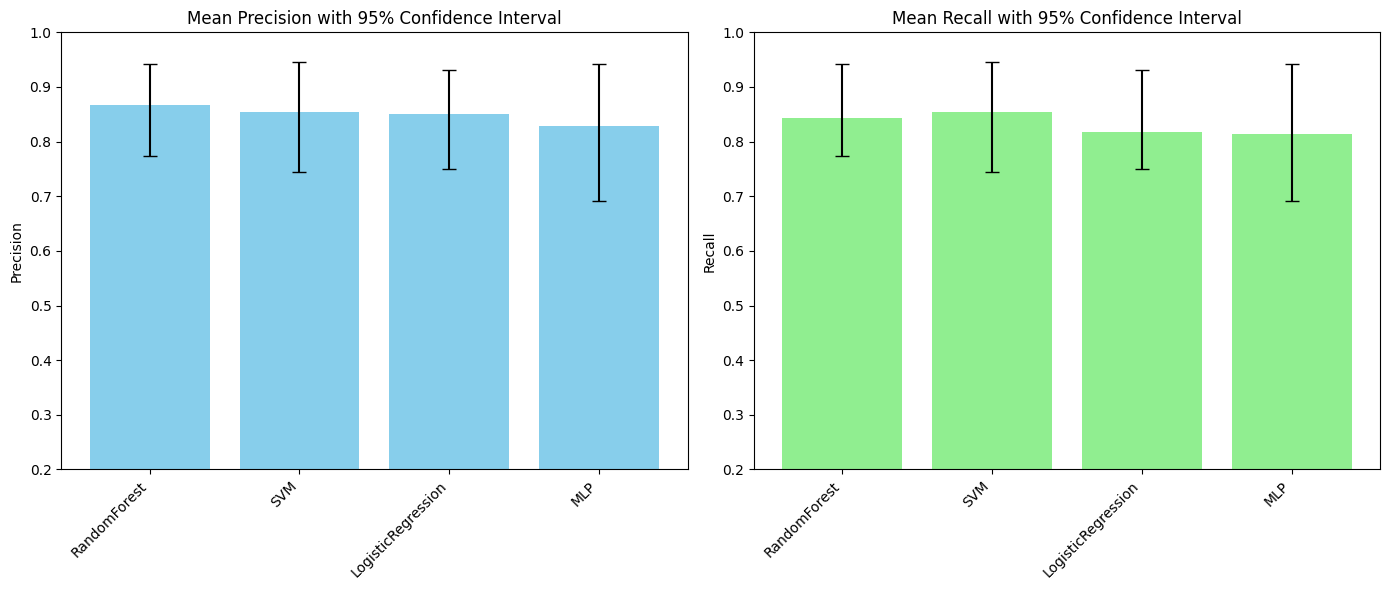

In [62]:
Evaluation(LR_precisions,LR_recalls,SVM_precisions,SVM_recalls,RF_precisions,RF_recalls,MLP_precisions,MLP_recalls)

#### Second machine performance

Mean Precision for Logistic Regression: 0.48567706681064426, 95% CI: [0.38149909 0.56918895]
Mean Recall for Logistic Regression: 0.5799392318276589, 95% CI: [0.48022813 0.65833333]
-------------------------------------------------------------------------------------------------
Mean Precision for Support Vector Machine: 0.521669299221665, 95% CI: [0.39196682 0.60654762]
Mean Recall for Support Vector Machine: 0.5853675838091306, 95% CI: [0.49366987 0.65041667]
-------------------------------------------------------------------------------------------------
Mean Precision for Random Forest: 0.4932939914363126, 95% CI: [0.40565889 0.58737179]
Mean Recall for Random Forest: 0.5710494493927324, 95% CI: [0.48637821 0.64583333]
-------------------------------------------------------------------------------------------------
Mean Precision for Multi Layer Perceptron: 0.5019645664243881, 95% CI: [0.3821875  0.60328982]
Mean Recall for Multi Layer Perceptron: 0.5924393001225852, 95% CI: [0.5  

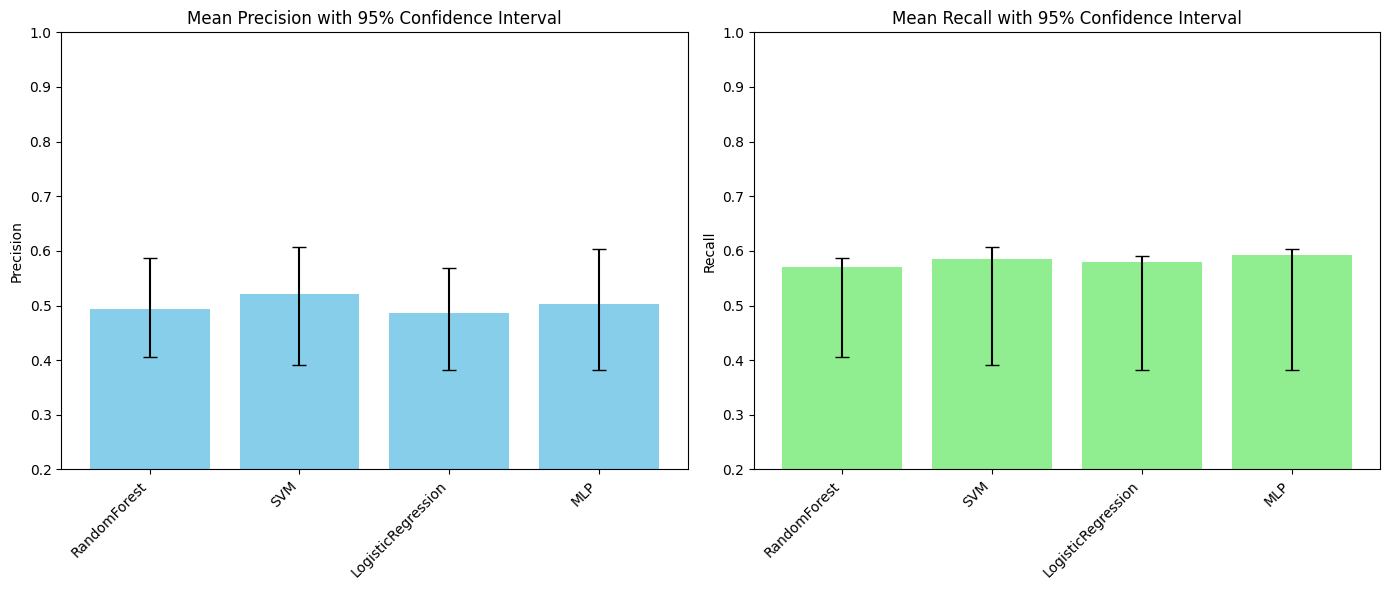

In [63]:
Evaluation(LR_precisions2,LR_recalls2,SVM_precisions2,SVM_recalls2,RF_precisions2,RF_recalls2,MLP_precisions2,MLP_recalls2)

#### Two machines overall performance

Mean Precision for Logistic Regression: 0.7721431738642025, 95% CI: [0.67519751 0.86124603]
Mean Recall for Logistic Regression: 0.7728212040224424, 95% CI: [0.67362676 0.87607026]
-------------------------------------------------------------------------------------------------
Mean Precision for Support Vector Machine: 0.792152196918704, 95% CI: [0.67607911 0.89426533]
Mean Recall for Support Vector Machine: 0.7915281309131815, 95% CI: [0.67922436 0.8902451 ]
-------------------------------------------------------------------------------------------------
Mean Precision for Random Forest: 0.7823179426077859, 95% CI: [0.676875   0.88465385]
Mean Recall for Random Forest: 0.7810645743189738, 95% CI: [0.64808837 0.88498188]
-------------------------------------------------------------------------------------------------
Mean Precision for Multi Layer Perceptron: 0.16327626954906724, 95% CI: [0.11730603 0.2       ]
Mean Recall for Multi Layer Perceptron: 0.1476318812325906, 95% CI: [0.097

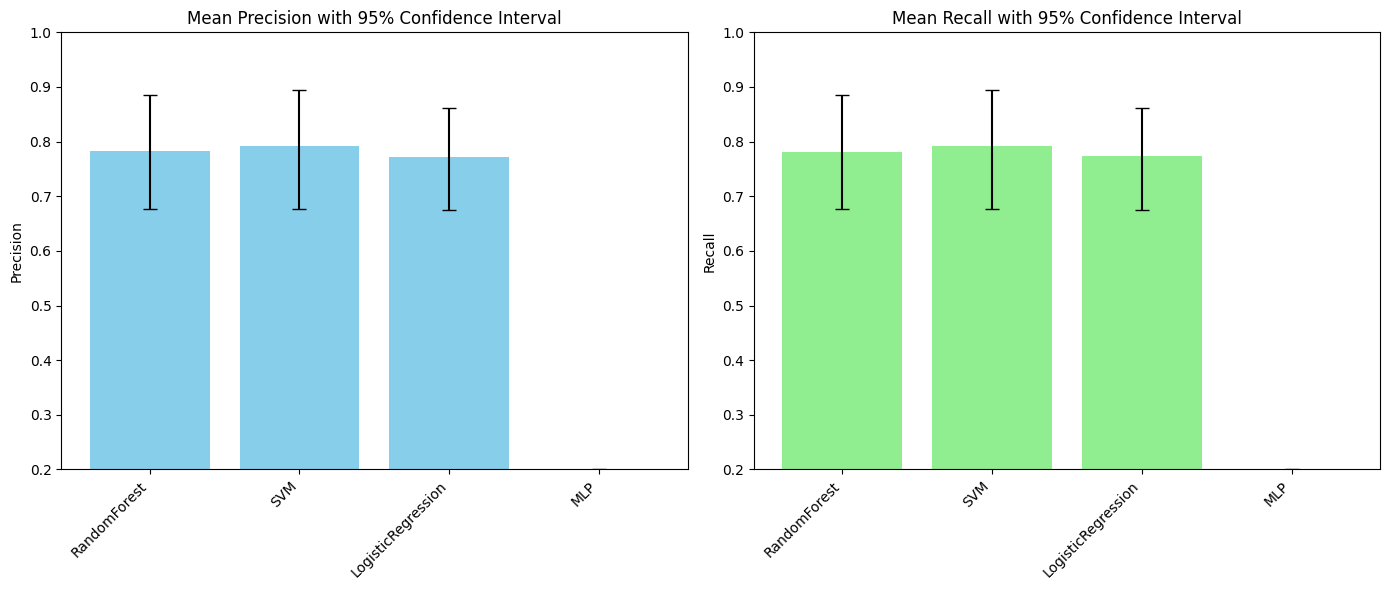

In [64]:
Evaluation(LR_precisions3,LR_recalls3,SVM_precisions3,SVM_recalls3,RF_precisions3,RF_recalls3,MLP_precisions3,MLP_recalls3)

As you can see, the results from the first machine are significantly better than those from the second machine, and the different classifiers performed mostly similar.

In comparison with the overall performance and the performance in Part 1, we can conclude that there is no significant change in results, except for the MLP model, which performs poorly in this task. This could be due to its sensitivity to the distribution of the data or its complexity in handling the hierarchical classification process.